<a href="https://colab.research.google.com/github/rwswzk/BusinessOOP/blob/main/MIS_515_JSSN_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Questions we want to answer:

1.What is the average strength of magnitude and length of depth from earthquake data?

2. Based on lat/long data, where are earthquakes likely to happen?

Regression lines: 3
depth v magnitude
# New Section
longitude v magnitude

latitude v magnitude

Heat map:
coalting depth v magnitude

In [ ]:
# Suppress output
%%capture
if 'google.colab' in str(get_ipython()):  # Check if running in Google Colab
    # Install required system libraries
    !apt install libspatialindex-dev
    # Install required Python packages
    !pip install fiona shapely pyproj rtree mapclassify
    !pip install geopandas
    !pip install openpyxl
    !pip install leafmap
    !pip install kaggle
    # Create a directory for storing Kaggle API key
    !mkdir ~/.kaggle

In [ ]:
import os                           # Import the os module for operating system functionality
import re                           # Import the re module for regular expressions
import pandas as pd                # Import the pandas library for data manipulation
import geopandas as gpd            # Import the geopandas library for working with geospatial data
import leafmap.foliumap as leafmap # Import the leafmap library for creating interactive maps
import matplotlib.pyplot as plt    # Import the matplotlib.pyplot module for plotting
import seaborn as sns              # Import the seaborn library for statistical data visualization
import scipy.stats as st           # linregress

In [ ]:
#Go to your Kaggle account, navigate to 'Account' > 'Create New API Token'.
#This will download a file named kaggle.json containing your API credentials.

# Import the files module from google.colab library for uploading files
from google.colab import files
# Upload the kaggle.json file
files.upload()
# Copy the uploaded kaggle.json file to the ~/.kaggle/ directory
!cp kaggle.json ~/.kaggle/
# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset using the Kaggle API
!kaggle datasets download -d alextitu/stead-chunk-2
# Import the zipfile module
import zipfile
# Extract the contents of the downloaded zip file to the 'data' directory
with zipfile.ZipFile('/content/stead-chunk-2.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Saving kaggle.json to kaggle (1).json
stead-chunk-2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
excel_file_1 = 'chunk2.csv'
data_folder = '/content/data'
excel_file_1_path = os.path.join(data_folder, excel_file_1)
raw_df = pd.read_csv(excel_file_1_path)
raw_df

,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,p_travel_sec,...,source_magnitude_author,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,trace_name
0,TA,109C,BH,32.8889,-117.105100,150.0,700.0,manual,0.50,17.080000,...,NaN,NaN,0.9200,102.09,159.3,[56.79999924 55.40000153 47.40000153],[[2896.]],2006-07-23 15:59:00.960000,earthquake_local,109C.TA_20060723155859_EV
1,TA,109C,BH,32.8889,-117.105100,150.0,600.0,manual,0.50,16.879999,...,NaN,NaN,0.9100,101.34,281.7,[65. 65.5 61.40000153],[[5508.]],2006-11-03 15:56:53.610000,earthquake_local,109C.TA_20061103155652_EV
2,TA,109C,BH,32.8889,-117.105100,150.0,500.0,manual,0.50,17.260000,...,NaN,NaN,0.9200,101.87,280.5,[37.20000076 42. 38.59999847],[[3114.]],2006-11-03 16:12:24.700000,earthquake_local,109C.TA_20061103161223_EV
3,TA,109C,BH,32.8889,-117.105100,150.0,900.0,manual,0.50,17.280001,...,NaN,NaN,0.9300,103.26,281.6,[54.09999847 54.90000153 45.5 ],[[3152.]],2006-11-14 13:32:22.540000,earthquake_local,109C.TA_20061114133221_EV
4,TA,109C,BH,32.8889,-117.105100,150.0,700.0,manual,0.50,18.139999,...,NaN,NaN,0.9200,102.48,4.7,[58.20000076 56.20000076 53.79999924],[[3134.]],2006-11-27 10:46:41.060000,earthquake_local,109C.TA_20061127104640_EV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,PB,B087,EH,33.4955,-116.602667,1139.0,692.0,autopicker,0.83,10.730000,...,CI,NaN,0.5665,62.21,327.7,[23.29999924 25. 20.89999962],[[2126.]],2011-11-02 15:32:01.620000,earthquake_local,B087.PB_20111102153200_EV
199996,PB,B087,EH,33.4955,-116.602667,1139.0,900.0,manual,0.67,7.160000,...,CI,NaN,0.3702,41.17,161.2,[26.20000076 25.70000076 24.60000038],[[2483.]],2011-11-02 19:07:21.300000,earthquake_local,B087.PB_20111102190720_EV
199997,PB,B087,EH,33.4955,-116.602667,1139.0,700.0,manual,0.59,4.630000,...,CI,NaN,0.1981,22.03,327.8,[11.89999962 12.30000019 10.60000038],[[1763.]],2011-11-02 20:03:03.500000,earthquake_local,B087.PB_20111102200302_EV
199998,PB,B087,EH,33.4955,-116.602667,1139.0,700.0,manual,0.62,3.460000,...,CI,NaN,0.1664,18.51,96.2,[22.29999924 16.89999962 16.39999962],[[1620.]],2011-11-02 21:17:42.080000,earthquake_local,B087.PB_20111102211741_EV


In [ ]:
# Drop unnecessary columns from raw_df to create clean_df
clean_df = raw_df.drop(["network_code", "receiver_latitude", "receiver_longitude", "receiver_elevation_m",
    "receiver_code", "receiver_type", "p_arrival_sample", "source_id", "p_status",
    "source_horizontal_uncertainty_km", "source_magnitude_type", "source_depth_uncertainty_km",
    "p_weight", "s_arrival_sample", "source_gap_deg", "source_error_sec", "s_status",
    "s_weight", "source_origin_uncertainty_sec", "source_mechanism_strike_dip_rake",
    "back_azimuth_deg", "source_magnitude_author", "snr_db", "coda_end_sample",
    "trace_category", "source_distance_deg", "trace_name", "trace_start_time"], axis=1)

# Reset the index of clean_df
clean_df = clean_df.reset_index()

# Reindex clean_df starting from 1
clean_df = clean_df.reindex(range(1, len(clean_df) + 1))

# Drop the last row of clean_df
clean_df.drop(clean_df.index[-1], inplace=True)

# Convert the 'index' column to integer type
clean_df['index'] = clean_df['index'].astype(int)

# Filter clean_df to create Feel_df and Damage_df based on source_magnitude

Feel_df = clean_df[clean_df['source_magnitude'] >= 3.0]
Damage_df = clean_df[clean_df['source_magnitude'] >= 4.0]
VDamage_df = clean_df[clean_df['source_magnitude'] >= 5.0]


# Display the updated clean_df
clean_df

,index,p_travel_sec,source_origin_time,source_latitude,source_longitude,source_depth_km,source_magnitude,source_distance_km
1,1,16.879999,2006-11-03 15:56:42.73,32.707700,-116.044600,9.20,4.30,101.34
2,2,17.260000,2006-11-03 16:12:12.44,32.725300,-116.034800,12.66,3.60,101.87
3,3,17.280001,2006-11-14 13:32:14.26,32.706300,-116.024100,11.50,3.80,103.26
4,4,18.139999,2006-11-27 10:46:29.92,31.967900,-117.194400,7.26,3.60,102.48
5,5,18.020000,2006-11-29 12:17:35.10,32.831200,-115.960300,9.73,3.80,107.34
...,...,...,...,...,...,...,...,...
199995,199995,10.730000,2011-11-02 15:31:57.810000,33.971167,-116.958333,15.53,1.37,62.21
199996,199996,7.160000,2011-11-02 19:07:23.140000,33.144333,-116.459500,8.76,1.44,41.17
199997,199997,4.630000,2011-11-02 20:03:05.870000,33.663333,-116.729500,14.36,0.63,22.03
199998,199998,3.460000,2011-11-02 21:17:45.620000,33.477667,-116.404667,8.58,0.68,18.51


In [ ]:
rows_to_drop = []
for index, row in clean_df.iterrows():
    try:
        row['source_depth_km'] = float(row['source_depth_km'])
        row['source_magnitude'] = float(row['source_magnitude'])
    except ValueError:
        # Add the index of the row to the list of rows to drop
        rows_to_drop.append(index)

# Drop the rows where conversion failed
float_df = clean_df.drop(rows_to_drop)
float_df

,index,p_travel_sec,source_origin_time,source_latitude,source_longitude,source_depth_km,source_magnitude,source_distance_km
1,1,16.879999,2006-11-03 15:56:42.73,32.707700,-116.044600,9.20,4.30,101.34
2,2,17.260000,2006-11-03 16:12:12.44,32.725300,-116.034800,12.66,3.60,101.87
3,3,17.280001,2006-11-14 13:32:14.26,32.706300,-116.024100,11.50,3.80,103.26
4,4,18.139999,2006-11-27 10:46:29.92,31.967900,-117.194400,7.26,3.60,102.48
5,5,18.020000,2006-11-29 12:17:35.10,32.831200,-115.960300,9.73,3.80,107.34
...,...,...,...,...,...,...,...,...
199995,199995,10.730000,2011-11-02 15:31:57.810000,33.971167,-116.958333,15.53,1.37,62.21
199996,199996,7.160000,2011-11-02 19:07:23.140000,33.144333,-116.459500,8.76,1.44,41.17
199997,199997,4.630000,2011-11-02 20:03:05.870000,33.663333,-116.729500,14.36,0.63,22.03
199998,199998,3.460000,2011-11-02 21:17:45.620000,33.477667,-116.404667,8.58,0.68,18.51


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming clean_df is your DataFrame
X = float_df[['source_depth_km']]
y = float_df['source_magnitude']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.28327841997645625


Mean Squared Error: 0.28327841997645625


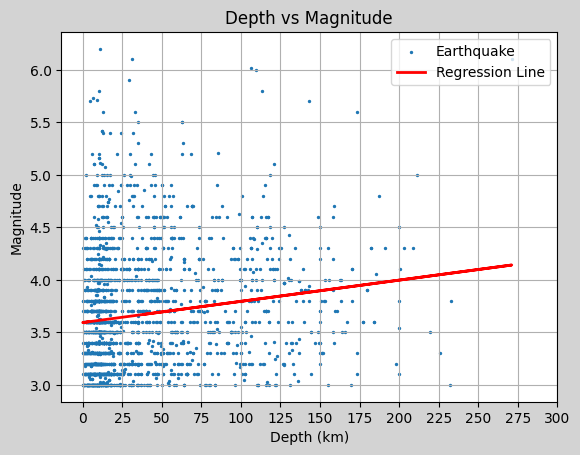

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Regression line and data for Earthquakes people can feel
# Selecting data for 'Feel_df'
X = Feel_df[['source_depth_km']]
y = Feel_df['source_magnitude']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the scatter plot with smaller points
plt.figure(facecolor='lightgrey')
plt.scatter(X_test, y_test, label='Earthquake', s=2)

# Plot the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Depth vs Magnitude')
plt.legend()
plt.grid(True)

# Set x-axis ticks to be every 25 km
plt.xticks(range(0, int(int_df['source_depth_km'].max()) + 25, 25))

plt.show()

Mean Squared Error: 0.14681930704949261


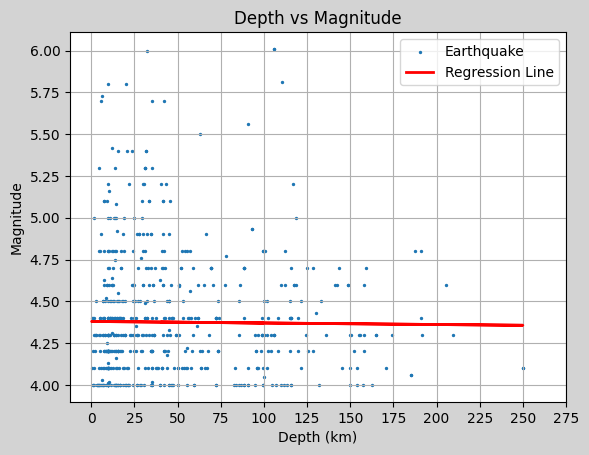

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Regression line for earthquakes that cause damage
X = Damage_df[['source_depth_km']]
y = Damage_df['source_magnitude']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Set the background color
fig = plt.figure(facecolor='lightgrey')

# Plot the scatter plot with smaller points
plt.scatter(X_test, y_test, label='Earthquake', s=2)

# Plot the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Depth vs Magnitude')
plt.legend()
plt.grid(True)

# Set x-axis ticks to be every 25 km
plt.xticks(range(0, int(Damage_df['source_depth_km'].max()) + 25, 25))

plt.show()

Mean Squared Error: 0.09328099684792732


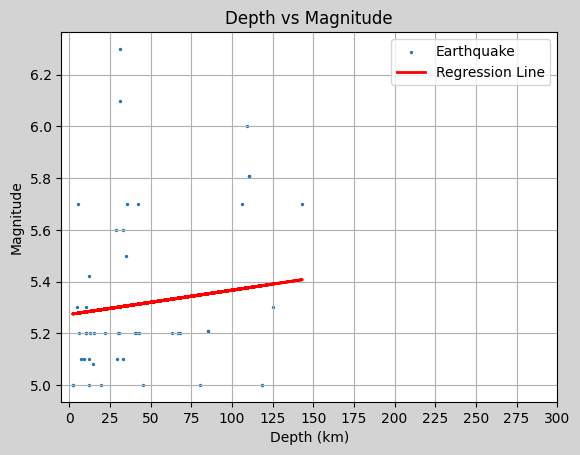

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Regression line and data for Earthquakes people can feel
# Selecting data for 'Feel_df'
X = VDamage_df[['source_depth_km']]
y = VDamage_df['source_magnitude']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the scatter plot with smaller points
plt.figure(facecolor='lightgrey')
plt.scatter(X_test, y_test, label='Earthquake', s=2)

# Plot the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Depth vs Magnitude')
plt.legend()
plt.grid(True)

# Set x-axis ticks to be every 25 km
plt.xticks(range(0, int(int_df['source_depth_km'].max()) + 25, 25))

plt.show()

Mean Squared Error: 0.6362349270376071


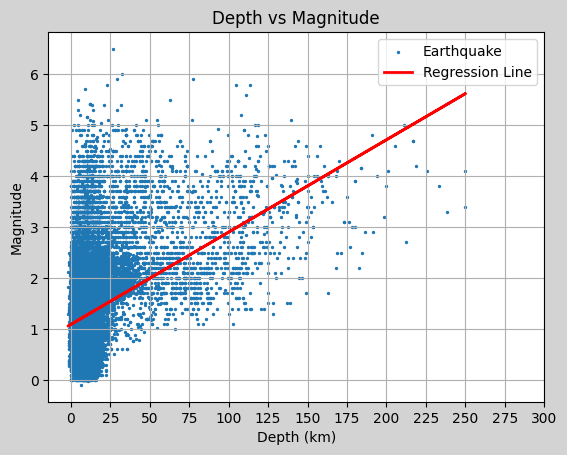

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Assuming clean_df is your DataFrame
X = clean_df[['source_depth_km']]
y = clean_df['source_magnitude']

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Set the background color
fig = plt.figure(facecolor='lightgrey')

# Plot the scatter plot with smaller points
plt.scatter(X_test, y_test, label='Earthquake', s=2)

# Plot the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Depth vs Magnitude')
plt.legend()
plt.grid(True)

# Set x-axis ticks to be every 25 km
plt.xticks(range(0, int(clean_df['source_depth_km'].max()) + 25, 25))

plt.show()


In [ ]:
rows_to_drop = []
for index, row in clean_df.iterrows():
    try:
        row['source_depth_km'] = int(row['source_depth_km'])
        row['source_magnitude'] = int(row['source_magnitude'])
    except ValueError:
        # Add the index of the row to the list of rows to drop
        rows_to_drop.append(index)

# Drop the rows where conversion failed
int_df = clean_df.drop(rows_to_drop)
int_df

,index,p_travel_sec,source_origin_time,source_latitude,source_longitude,source_depth_km,source_magnitude,source_distance_km
32768,32768,15.020000,2009-05-29 07:27:06.98,37.857400,23.014300,13.56,3.80,92.71
32769,32769,12.290000,2009-05-29 13:58:28.61,38.986500,22.276500,12.37,2.90,72.43
32770,32770,6.580000,2009-05-29 17:47:33.02,38.539600,23.442700,11.78,3.20,40.44
32771,32771,19.990000,2009-05-31 04:43:31.41,39.447800,23.722700,3.25,2.90,103.51
32772,32772,16.719999,2009-06-05 13:12:25.68,39.319300,23.843100,9.33,3.40,99.54
...,...,...,...,...,...,...,...,...
199995,199995,10.730000,2011-11-02 15:31:57.810000,33.971167,-116.958333,15.53,1.37,62.21
199996,199996,7.160000,2011-11-02 19:07:23.140000,33.144333,-116.459500,8.76,1.44,41.17
199997,199997,4.630000,2011-11-02 20:03:05.870000,33.663333,-116.729500,14.36,0.63,22.03
199998,199998,3.460000,2011-11-02 21:17:45.620000,33.477667,-116.404667,8.58,0.68,18.51


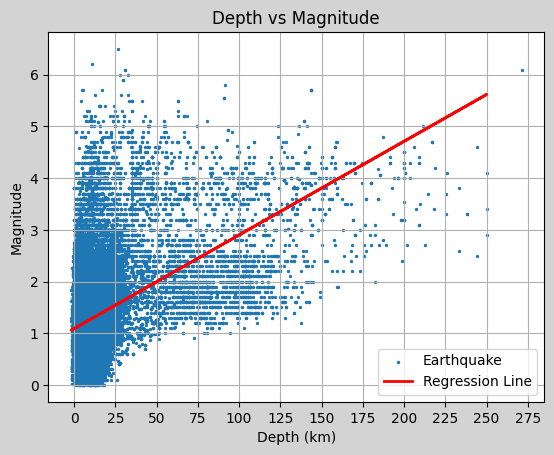

In [ ]:
import matplotlib.pyplot as plt

# Set the background color
fig = plt.figure(facecolor='lightgrey')

# Plot the scatter plot with smaller points
plt.scatter(int_df['source_depth_km'], int_df['source_magnitude'], label='Earthquake', s=2)

# Plot the regression line
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')

plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.title('Depth vs Magnitude')
plt.legend()
plt.grid(True)

# Set x-axis ticks to be every 25 km
plt.xticks(range(0, int(int_df['source_depth_km'].max()) + 25, 25))

plt.show()



In [ ]:
heatmap_df=clean_df.drop(["index","p_travel_sec","source_origin_time","source_depth_km","source_distance_km"], axis=1)
# Reset the index of clean_df
#heatmap_df =heatmap_df.reset_index()

# Reindex clean_df starting from 1
#heatmap_df = heatmap_df.reindex(range(1, len(clean_df) + 1))

# Drop the last row of clean_df
#heatmap_df.drop(heatmap_df.index[-1], inplace=True)

# Convert the 'index' column to integer type
#heatmap_df['index'] = heatmap_df['index'].astype(int)

# Display the updated clean_df
heatmap_df

,source_latitude,source_longitude,source_magnitude
1,32.707700,-116.044600,4.30
2,32.725300,-116.034800,3.60
3,32.706300,-116.024100,3.80
4,31.967900,-117.194400,3.60
5,32.831200,-115.960300,3.80
...,...,...,...
199995,33.971167,-116.958333,1.37
199996,33.144333,-116.459500,1.44
199997,33.663333,-116.729500,0.63
199998,33.477667,-116.404667,0.68


In [ ]:
rows_to_drop = []
for index, row in heatmap_df.iterrows():
    try:
        row['source_latitude'] = float(row['source_latitude'])
        row['source_longitude'] = float(row['source_longitude'])
    except ValueError:
        # Add the index of the row to the list of rows to drop
        rows_to_drop.append(index)

# Drop the rows where conversion failed
heatmap_df = heatmap_df.drop(rows_to_drop)
heatmap_df

,source_latitude,source_longitude,source_magnitude
1,32.707700,-116.044600,4.30
2,32.725300,-116.034800,3.60
3,32.706300,-116.024100,3.80
4,31.967900,-117.194400,3.60
5,32.831200,-115.960300,3.80
...,...,...,...
199902,34.307500,-116.973833,1.40
199942,32.811833,-116.165167,1.35
199951,32.851000,-116.039167,1.38
199970,32.793833,-116.143500,1.11


In [ ]:
heatmap_df = heatmap_df.drop_duplicates(subset='source_latitude',keep='first')
heatmap_df = heatmap_df.drop_duplicates(subset='source_longitude',keep='first')
heatmap_df

,source_latitude,source_longitude,source_magnitude
1,32.707700,-116.044600,4.30
2,32.725300,-116.034800,3.60
3,32.706300,-116.024100,3.80
4,31.967900,-117.194400,3.60
5,32.831200,-115.960300,3.80
...,...,...,...
199849,32.829500,-116.205667,1.40
199855,33.115333,-116.416500,0.79
199942,32.811833,-116.165167,1.35
199951,32.851000,-116.039167,1.38


In [ ]:
plt.figure(figsize=(12, 8))
pivot_table = heatmap_df.pivot(index="source_latitude",columns="source_longitude",values="source_magnitude")
plt.xlabel("source_longitude", size = 15)
plt.ylabel("source_latitude", size = 15)
plt.titlel("source_magnitude", size = 15)
sns.heatmap(pivot_table, annot=True, fmt=".1f", linewidths=.5, square = True, cmap= "coolwarm")

In [ ]:
plt.figure(figsize=(12, 8))
pivot_table = heatmap_df.pivot
sns.heatmap(pivot_table, annot=True, fmt=".1f", linewidths=.5, square = True, cmap= "coolwarm")

ValueError: Must pass 2-d input. shape=()

<Figure size 1200x800 with 0 Axes>

In [ ]:
heatmap_matrix = heatmap_df

sns.heatmap(heatmap_matrix, cmap="YlGnBu", annot=True, fmt="0.0f")

plt.show()

Error in callback <function flush_figures at 0x7ca97370c280> (for post_execute):


KeyboardInterrupt: 

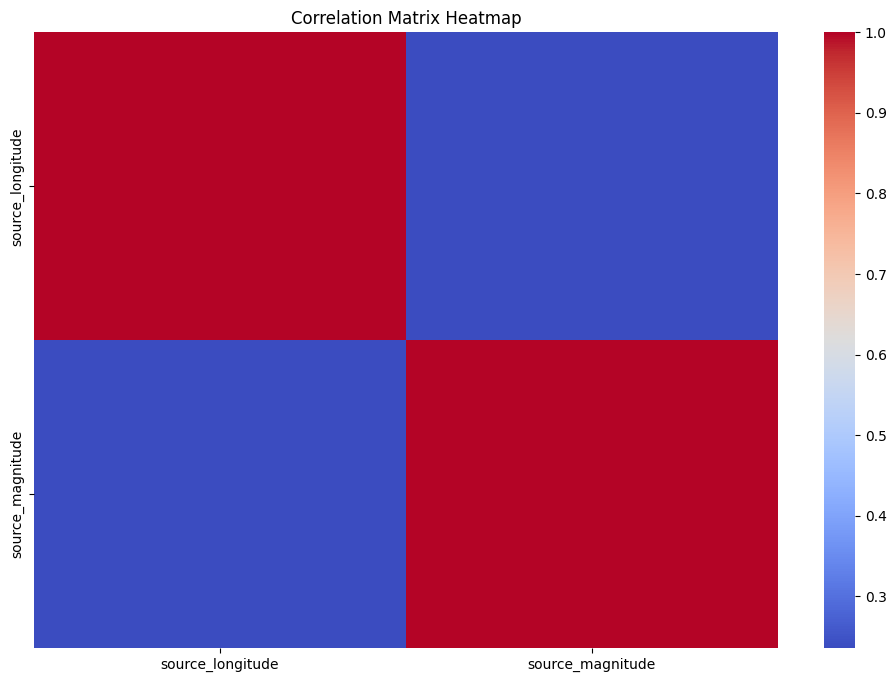

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the selected columns
correlation_matrix = clean_df.drop(["index","p_travel_sec","source_origin_time","source_latitude","source_depth_km","source_distance_km"], axis=1).corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
#linregress

x = np.array([0, 3, 7, 10])
y = np.array([5, 5, 27, 31])

model = st.linregress(x,y)
print(model)

print("Predicted value for X=3:",np.dot([3, 1],[model[0], model[1]]))